<h1>Clustering with PhenoGraph</h1>

The PDMC samples have been gated by a supervised algorithm, providing one methodology for feature extraction. Clustering is another method that can be used to this end. This is an 'unbiased' approach as events are clustered together based on simularities in high dimensional space as opposed to gating, which is biased to sequential selection of events in two-dimensional plots.

In [1]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.explorer import Explorer
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

/home/rossco/immunova/env/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/rossco/immunova/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<h2>Clustering on a concatenated sample</h2>

Clustering can be performed on a per-sample basis and clusters matched between samples. This provides added complexity in that a suitable method must be chosen for matching clusters together. According to the literature, QFMatch (an adaption of the quadratic distance metric) is the best performing method. With that being said it is a complicated method that has not been validated across multiple datasets. The original method used in the PhenoGraph paper and has been replicated in multiple studies is medoid meta-clustering with PhenoGraph. Later on I will be using both methods. 

First I will take a concatenated sample and apply PhenoGraph clustering. This has the risk that the clustering algorithm will capture information that discerns patients from one another than some other global information relating to disease progression, cause or outcome. This first approach is purely exploratory.

The Explorer class provides an object for loading all data associated to an experiment, labelling it, performing PhenoGraph clustering, and visualising using a manifold learning technique such as UMAP or PHATE.

In [2]:
texp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()

In [3]:
exclude = [f'{x}_pdmc_t' for x in ['209-03', '210-14', '273-01', 
                                   '298-01', '322-01', '237-06', 
                                   '302-01', '307-01']]
exclude.append('PD_T_PDMCs_sampled_data')
samples = [s for s in texp.list_samples() if s not in exclude]

In [4]:
len(samples)

37

In [5]:
explore = Explorer(root_population='single_Live_CD3+', transform='logicle')

In [6]:
explore.load_data(experiment=texp, samples=samples, sample_n=10000)

------------ Loading flow data: PD_T_PDMCs ------------



------------ Completed! ------------


In [7]:
explore.data.shape

(331755, 22)

We're left with a dataframe of concatenated single cell data (10000 cells from each sample). There is total of 331,755 data points and 22 columns. The column names are listed below:

In [8]:
explore.data.columns

Index(['CCR7', 'CD161', 'CD27', 'CD3', 'CD4', 'CD45RA', 'CD8', 'CXCR3',
       'FSC-A', 'FSC-H', 'FSC-W', 'L/D', 'PanGD', 'SSC-A', 'SSC-H', 'SSC-W',
       'Time', 'Va7.2', 'Vd2', 'original_index', 'population_label', 'pt_id'],
      dtype='object')

Before we cluster and visualise, it would be useful to associate the single cell data in this dataframe to clinical meta-data. Immunova is built around a document database where each flow file is associated directly with the clinical meta data. This means we can simple choose a common field name like 'status' or 'gender' and assoicate it to our single cell data. We can also access timeseries data and data with 'depth' such as the pathogens isolated from a patient and things like gram-status and HMBPP stauts.

We use the following methods of our Explorer object to associate single cell data to clinical meta-data:
* `load_meta` - given a field name associate to single cell data
* `load_biology_data` - summarise a blood test or some other time series data
* `load_infectious_data` - summarise the infectious agents isolate from each patient; creates four new columns, one with a list of organisms isolated, one with the common isolate type e.g. bacteria/virus/fungal, the common gram status amongst isolates, and the common HMBPP/Ribo status

In [9]:
help(explore.load_meta)

Help on method load_meta in module immunova.flow.explorer:

load_meta(variable: str) method of immunova.flow.explorer.Explorer instance
    Load meta data for each patient. Must be provided with a variable that is a field with a single value
    NOT an embedded document. A column will be generated in the Pandas DataFrame stored in the attribute 'data'
    that pertains to the variable given and the value will correspond to that of the patients.
    :param variable: field name to populate data with



In [10]:
help(explore.load_biology_data)

Help on method load_biology_data in module immunova.flow.explorer:

load_biology_data(test_name: str, summary_method: str = 'average') method of immunova.flow.explorer.Explorer instance
    Load the pathology results of a given test from each patient and populate 'data' accordingly. As multiple
    results may exist for one particular test, a summary method should be provided, this should have a value as
    follows:
    * average - the average test result is generated and stored
    * max - the maximum value is stored
    * min - the minimum value is stored
    * median - the median test result is generated and stored



In [11]:
help(explore.load_infectious_data)

Help on method load_infectious_data in module immunova.flow.explorer:

load_infectious_data(multi_org: str = 'list') method of immunova.flow.explorer.Explorer instance
    Load the bug data from each patient and populate 'data' accordingly. As default variables will be created as
    follows:
    * organism_name = If 'multi_org' equals 'list' then multiple organisms will be stored as a comma separated list
    without duplicates, whereas if the value is 'mixed' then multiple organisms will result in a value of 'mixed'.
    * organism_type = value of either 'gram positive', 'gram negative', 'virus', 'mixed' or 'fungal'
    * hmbpp = True or False based on HMBPP status (Note: it only takes one positive organism for this value to be
    True)
    * ribo = True or False based on Ribo status (Note: it only takes one positive organism for this value to be
    True)



In [12]:
explore.load_meta(variable='status')

In [13]:
explore.data.columns

Index(['CCR7', 'CD161', 'CD27', 'CD3', 'CD4', 'CD45RA', 'CD8', 'CXCR3',
       'FSC-A', 'FSC-H', 'FSC-W', 'L/D', 'PanGD', 'SSC-A', 'SSC-H', 'SSC-W',
       'Time', 'Va7.2', 'Vd2', 'original_index', 'population_label', 'pt_id',
       'status'],
      dtype='object')

In [14]:
explore.load_infectious_data()

In [15]:
explore.data.columns

Index(['CCR7', 'CD161', 'CD27', 'CD3', 'CD4', 'CD45RA', 'CD8', 'CXCR3',
       'FSC-A', 'FSC-H', 'FSC-W', 'L/D', 'PanGD', 'SSC-A', 'SSC-H', 'SSC-W',
       'Time', 'Va7.2', 'Vd2', 'original_index', 'population_label', 'pt_id',
       'status', 'organism_name', 'organism_type', 'hmbpp', 'ribo'],
      dtype='object')

In [17]:
explore.data.organism_name.unique()

array(['Staphylococcus epidermis', 'Unknown', 'Enterobacter species',
       'Coagulase Negative Staphylococcus', 'Staphylococcus aureus',
       'Yeast', 'Alpha Haemolytic Streptococcus', 'Streptococcus mitis',
       'Corynebacterium amycolatum'], dtype=object)

<h3>PhenoGraph clustering</h3>

I'll now use the PhenoGraph algorithm with a k=30 to cluster single cell data on this concatenation of all patients.

In [18]:
features = ['CCR7', 'CD161', 'CD27', 'CD4', 'CD45RA', 'CD8', 'CXCR3',
            'FSC-A', 'FSC-H', 'FSC-W', 'PanGD', 'SSC-A', 'SSC-H', 'SSC-W',
            'Va7.2', 'Vd2']

In [22]:
explore.data[features].head()

,CCR7,CD161,CD27,CD4,CD45RA,CD8,CXCR3,FSC-A,FSC-H,FSC-W,PanGD,SSC-A,SSC-H,SSC-W,Va7.2,Vd2
0,0.314096,0.143977,0.115868,0.359975,0.265690,0.256996,0.344031,0.910921,0.875326,NaN,0.092609,0.849198,NaN,0.882189,0.348076,0.163224
1,0.252092,0.124231,0.108327,0.358234,0.278323,0.233635,0.342267,0.756497,0.731804,NaN,0.082894,0.861271,NaN,0.893098,0.377044,0.146978
2,0.336972,0.189160,0.256796,0.427699,0.273953,0.686293,0.343221,0.914021,0.882587,NaN,0.059161,0.860154,NaN,0.879292,0.399576,0.165935
3,0.183506,0.124260,0.101012,0.105199,0.146271,0.132413,0.110670,0.704059,0.687184,NaN,0.052495,0.638961,NaN,0.881787,0.105355,0.116732
4,0.301040,0.120671,0.196876,0.479939,0.398108,0.342750,0.359458,0.921268,0.895870,NaN,0.022729,0.856237,NaN,0.878322,0.404114,0.193799


In [23]:
# Exclide FSC-W and SSC-H as this is missing for some samples
features = ['CCR7', 'CD161', 'CD27', 'CD4', 'CD45RA', 'CD8', 'CXCR3',
            'FSC-A', 'FSC-H', 'PanGD', 'SSC-A', 'SSC-W',
            'Va7.2', 'Vd2']

In [24]:
explore.phenograph_clustering(features=features)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 198.87367987632751 seconds
Jaccard graph constructed in 83.74508762359619 seconds
Wrote graph to binary file in 32.13160991668701 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.880175
After 14 runs, maximum modularity is Q = 0.881835
Louvain completed 34 runs in 1669.1129760742188 seconds
PhenoGraph complete in 1984.9926495552063 seconds


In [25]:
len(explore.data['PhenoGraph labels'].unique())

44

PhenoGraph generated 44 clusters. It is worth noting that PhenoGraph tends to 'over-cluster' (that is, it is a very sensitive technique) but it has the benefit of being non-parametric and is not biased by a user defined number of clusters or other hyperparamters.

<h3>Visualisation</h3>

Now that we have clustered the concatenated single cell data we can explore the data using dimensionality reduction techeniques. Immunova exclusively employs the manifold learning techniques UMAP and PHATE as they capture both local and global structure. These methods also scale easily to large datasets.

We can use UMAP and PHATE to see if any particular clusters/gated populations correlate with our clinical meta data. Any patterns found will be confirmed by embedded feature elimination and inference testing.

ValueError: Label global clustering is invalid; must be either a column name in the existing dataframe (['CCR7', 'CD161', 'CD27', 'CD3', 'CD4', 'CD45RA', 'CD8', 'CXCR3', 'FSC-A', 'FSC-H', 'FSC-W', 'L/D', 'PanGD', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'Va7.2', 'Vd2', 'original_index', 'population_label', 'pt_id', 'status', 'organism_name', 'organism_type', 'hmbpp', 'ribo', 'PhenoGraph labels']), "global clusters" which labels events according to clustering on the concatenated dataset, or "gated populations" which are common populations gated on a per sample basis.

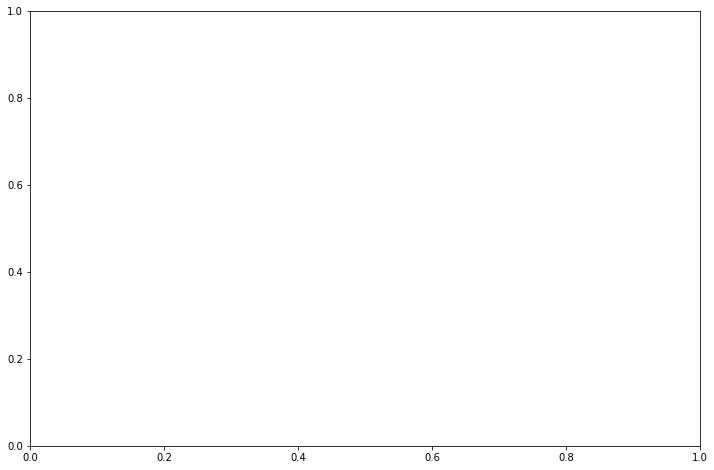

In [28]:
# Basic UMAP of global clustering
ax = explore.scatter_plot(features=features, primary_label='global clustering', dim_reduction_method='UMAP')

In [ ]:
ax